# How to combine ScanFields of multiple detectors.
In this notbook, we demonstrate the sumation of scan field which including cross-link

In [1]:
%load_ext autoreload
%autoreload 2
import litebird_sim as lbs
import numpy as np
import healpy as hp
import sbm
import logging
import toml
from pathlib import Path
import matplotlib.pyplot as plt
#from rich import print
logging.basicConfig(level=logging.WARNING)

In [2]:
# Load your Imo in litebird_sim

CONFIG_PATH = Path.home() / ".config" / "litebird_imo"
CONFIG_FILE_PATH = CONFIG_PATH / "imo.toml"
tomlinfo = toml.load(CONFIG_FILE_PATH)
flatfile_location = tomlinfo["repositories"][0]["location"]

imo_version = "v2"
imo = lbs.Imo(flatfile_location=flatfile_location)

In [ ]:
# Load LiteBIRD channel from SBM's channel list
channel = sbm.channel_list[1]
# Define the telescope
telescope = channel[0] + "FT"
print("Channel: ", channel)

# Load the channel info
ch_info = lbs.FreqChannelInfo.from_imo(
    url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info", imo=imo
)

Channel:  L2-050


Let's collect detector's name:

In [ ]:
dets_list = ch_info.detector_names
print(f"Num of detectors: {len(dets_list)}\n")
print("Detector names: ")
for det in dets_list:
    print(det)

Num of detectors: 24

Detector names: 
000_000_000_QA_050_T
000_000_000_QA_050_B
000_000_001_QB_050_T
000_000_001_QB_050_B
000_000_002_UA_050_T
000_000_002_UA_050_B
000_003_000_UB_050_T
000_003_000_UB_050_B
000_003_001_UA_050_T
000_003_001_UA_050_B
000_003_002_QB_050_T
000_003_002_QB_050_B
000_004_002_UA_050_T
000_004_002_UA_050_B
000_004_001_QB_050_T
000_004_001_QB_050_B
000_004_000_QA_050_T
000_004_000_QA_050_B
000_007_002_QB_050_T
000_007_002_QB_050_B
000_007_001_UA_050_T
000_007_001_UA_050_B
000_007_000_UB_050_T
000_007_000_UB_050_B


SBM's `.load_channel()` has arguments like below:

```python
sbm.load_channel(cls, channel: str, detector_list=None, base_path=DB_ROOT_PATH)
```


If `detector_list` is `None`, every **TOP** detector (i.e. ignore Bottom detector) in the channel will be loaded and hit-map and cross-links are also combined automatically. 

So, cancelation of ${}_{2}\tilde{h}$ will never happen. 
Now, let's demonstrait it!

In [5]:
# Load every detector in the channel
sf = sbm.ScanFields.load_channel(channel)

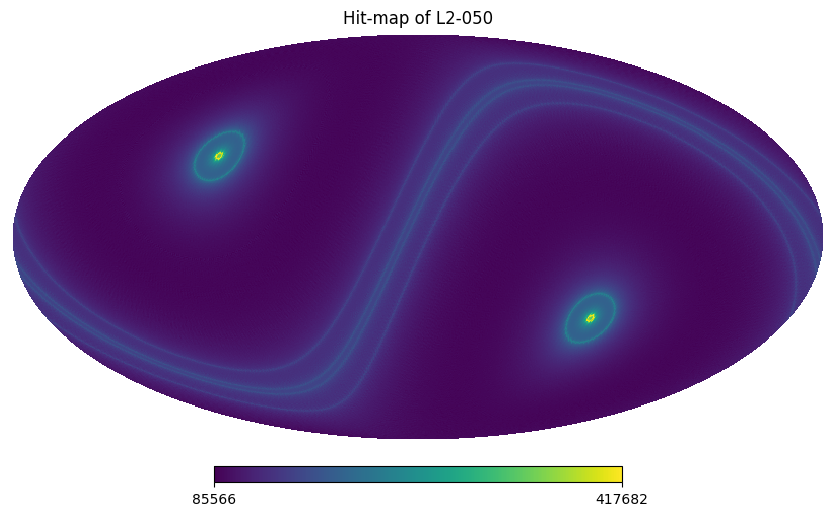

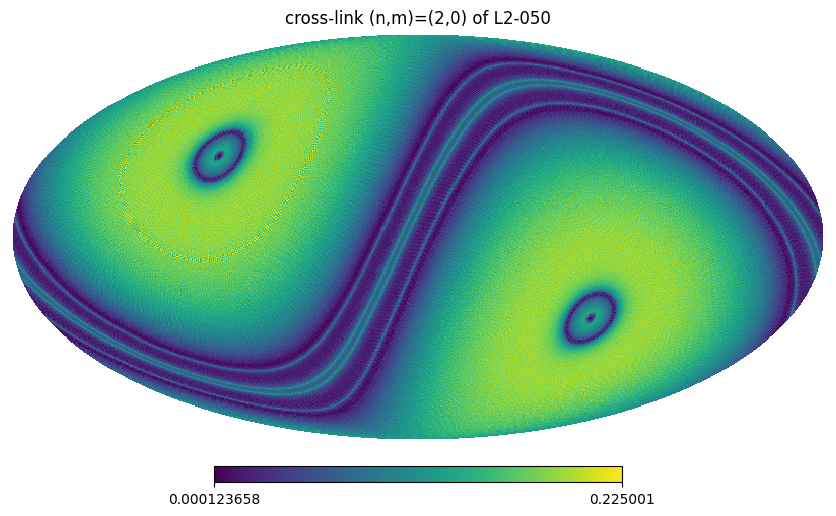

In [6]:
hp.mollview(sf.hitmap, title=f"Hit-map of {channel}")
hp.mollview(np.abs(sf.get_xlink(2,0)), title=f"cross-link (n,m)=(2,0) of {channel}")

Now, let's input exact detector name as below:

In [7]:
# Load every detector in the channel
sf = sbm.ScanFields.load_channel(channel, detector_list=dets_list)

Now, we can see the hit-map twice larger than before because we took into account bottm detector now. And we can observe cancelation of cross-link.

We have to consider what kind of cross-link do we need. 

For example, if we consider differential gain. If we make cross-link by top and bottom detector, the temperature leakage what we may want to simulate will be disapper because we canceled out the important spin-(2,0) cross-link for differential gain. 

In this case, we have to make the cross-link either top or bottom detectors. 

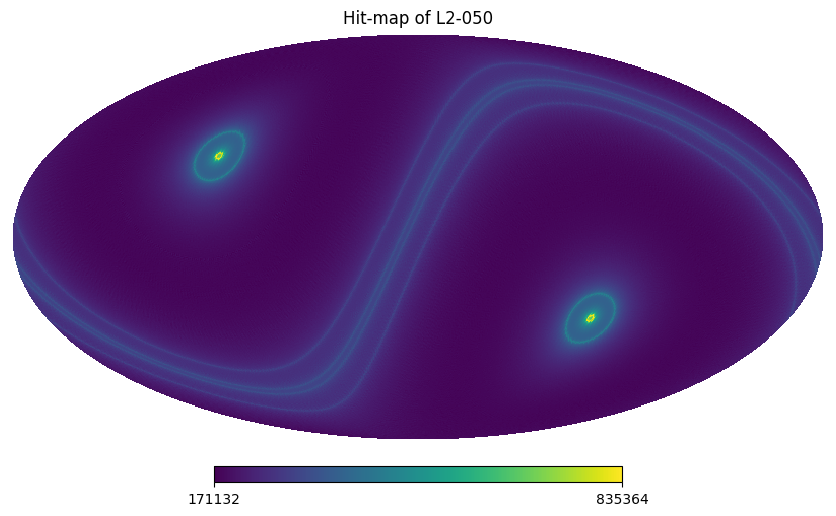

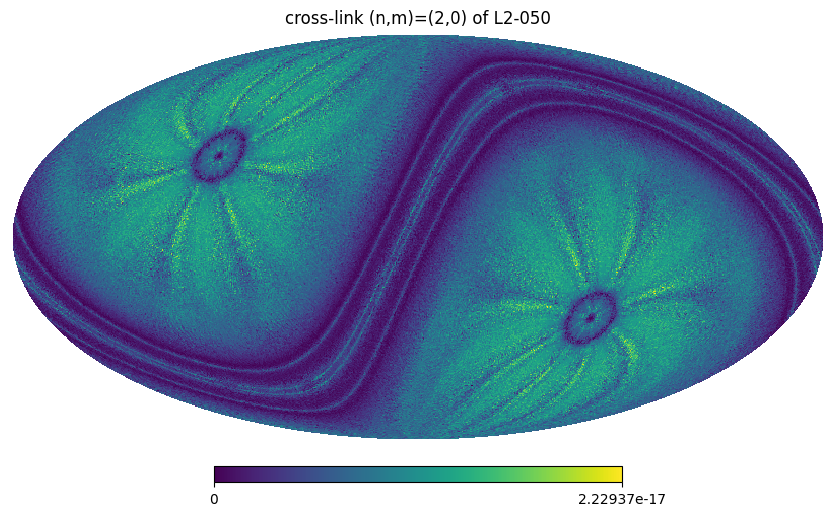

In [8]:
hp.mollview(sf.hitmap, title=f"Hit-map of {channel}")
hp.mollview(np.abs(sf.get_xlink(2,0)), title=f"cross-link (n,m)=(2,0) of {channel}")

# Let's consider the bandpass mismatch by reusing the differential gain function. 
- We define the differential gain paramter per band. 
- Reconstract polarization map by 2x2 map-making matrix so, the leakage is dominated by temperature 
- We generate random number for $\gamma_T$ and $\gamma_B$ which represents the bandpass per detector.
- Plot residdual map $\Delta Q$ and $\Delta U$, and $\frac{\Delta Q}{I_{\rm Gal}}$ and $\frac{\Delta U}{I_{\rm Gal}}$ like [Thuong](https://arxiv.org/abs/1706.09486) et al. is doing. 

Note: Some detectors in MHFT can not observe pole, so they can not estimate stokes paramter due to a boosting of covariance matrix.
As we can see in below.

Running channel: L1-040
Used dets:  000_000_003_QA_040_T 000_000_004_QB_040_T 000_000_005_UA_040_T 000_000_006_UA_040_T 000_000_007_UB_040_T
Running channel: L2-050
Used dets:  000_000_000_QA_050_T 000_000_001_QB_050_T 000_000_002_UA_050_T 000_003_000_UB_050_T 000_003_001_UA_050_T
Running channel: L1-060
Used dets:  000_000_003_QA_060_T 000_000_004_QB_060_T 000_000_005_UA_060_T 000_000_006_UA_060_T 000_000_007_UB_060_T
Running channel: L3-068
Used dets:  000_001_018_UA_068_T 000_001_019_UB_068_T 000_001_020_QA_068_T 000_001_021_QB_068_T 000_001_022_UA_068_T
Running channel: L2-068
Used dets:  000_000_000_QA_068_T 000_000_001_QB_068_T 000_000_002_UA_068_T 000_003_000_UB_068_T 000_003_001_UA_068_T
Running channel: L4-078
Used dets:  000_001_000_QA_078_T 000_001_001_QB_078_T 000_001_002_UA_078_T 000_001_003_UB_078_T 000_001_004_QA_078_T
Running channel: L1-078
Used dets:  000_000_003_QA_078_T 000_000_004_QB_078_T 000_000_005_UA_078_T 000_000_006_UA_078_T 000_000_007_UB_078_T
Running chann

/gpfs/home/cmb/yusuket/program/map-make/SBMs/master/SBM/sbm/scan_fields.py:282: RuntimeWarning: invalid value encountered in divide
  instance.h /= instance.hitmap[:, np.newaxis, np.newaxis]


Running channel: M2-119
Used dets:  001_000_000_45A_119_B 001_000_002_00A_119_B 001_000_004_45A_119_B 001_000_006_00A_119_B 001_000_008_45A_119_B
Running channel: M1-140
Used dets:  001_002_000_45A_140_B 001_002_002_00A_140_B 001_002_004_45A_140_B 001_002_006_00A_140_B 001_002_008_45A_140_B
Running channel: M2-166
Used dets:  001_000_000_45A_166_B 001_000_002_00A_166_B 001_000_004_45A_166_B 001_000_006_00A_166_B 001_000_008_45A_166_B
Running channel: M1-195
Used dets:  001_002_000_45A_195_B 001_002_002_00A_195_B 001_002_004_45A_195_B 001_002_006_00A_195_B 001_002_008_45A_195_B
Running channel: H1-195
Used dets:  002_000_000_Q_195_B 002_000_002_Q_195_B 002_000_004_Q_195_B 002_000_006_Q_195_B 002_000_008_U_195_B
Running channel: H2-235
Used dets:  002_001_000_Q_235_B 002_001_002_Q_235_B 002_001_004_Q_235_B 002_001_006_Q_235_B 002_001_008_U_235_B
Running channel: H1-280
Used dets:  002_000_000_Q_280_B 002_000_002_Q_280_B 002_000_004_Q_280_B 002_000_006_Q_280_B 002_000_008_U_280_B
Running 

/tmp/ipykernel_2465676/3379352019.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,5))


Running channel: H3-402
Used dets:  002_002_000_Q_402_B 002_002_002_Q_402_B 002_002_004_Q_402_B 002_002_006_Q_402_B 002_002_008_Q_402_B


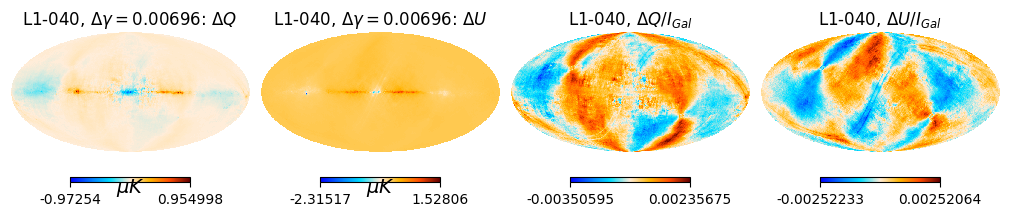

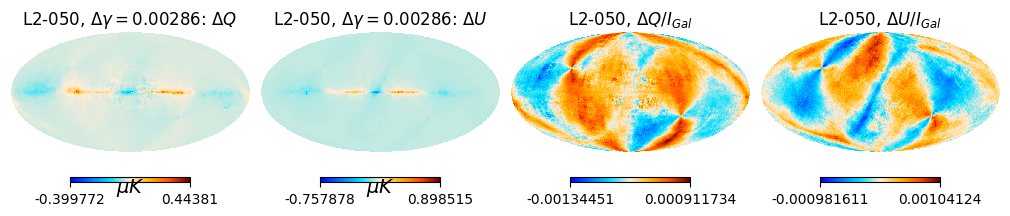

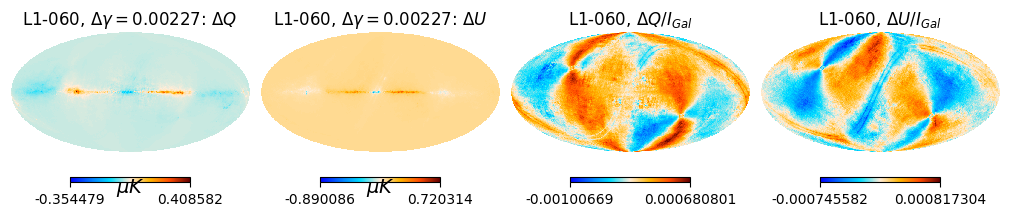

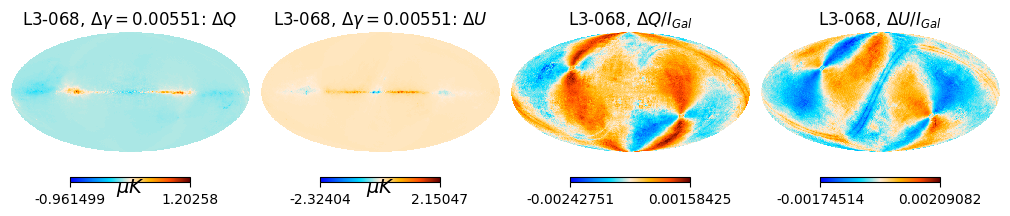

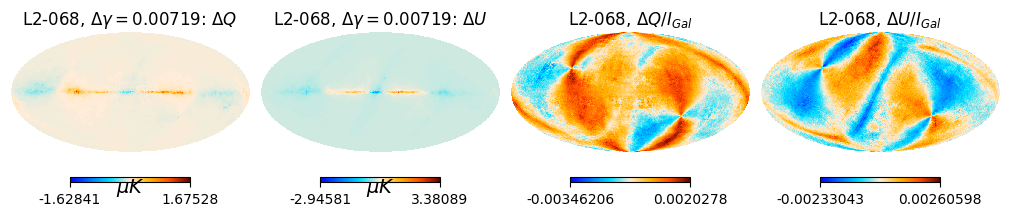

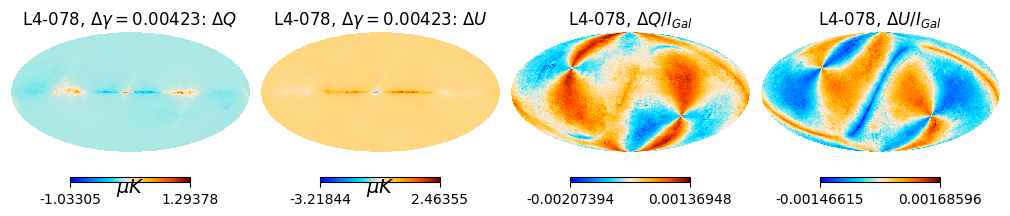

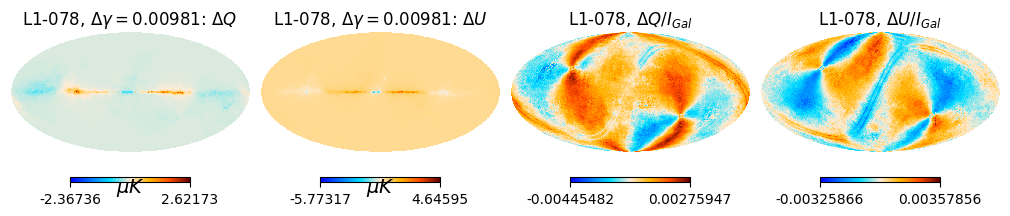

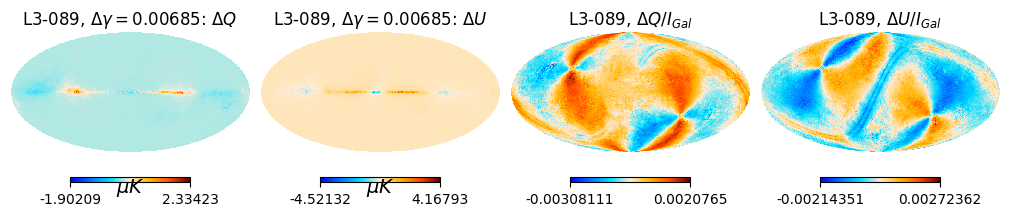

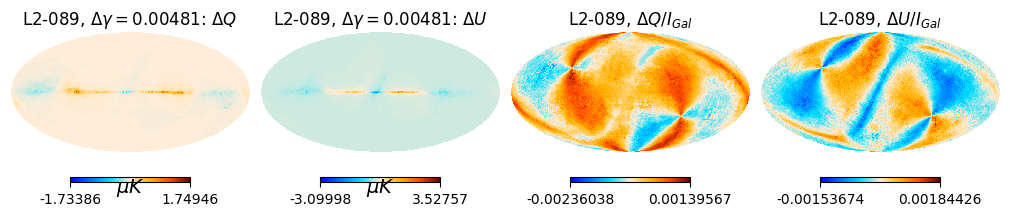

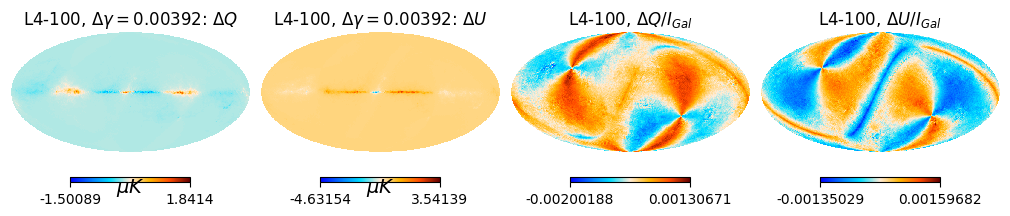

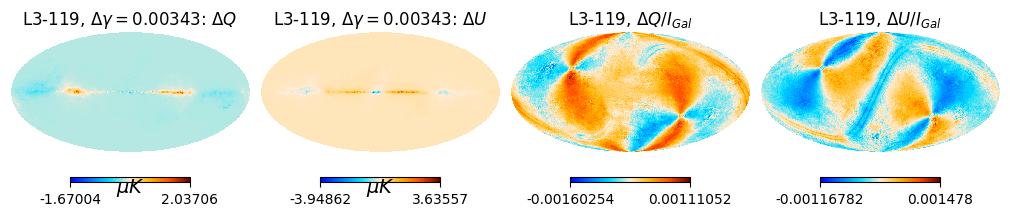

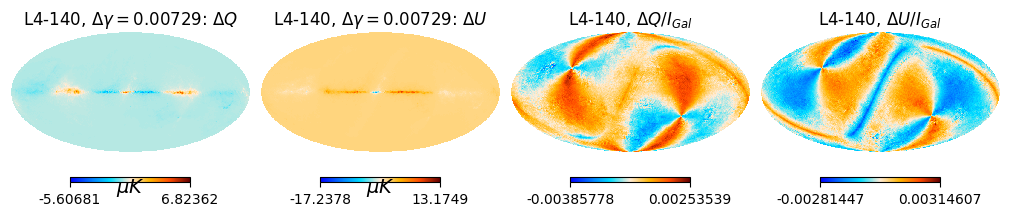

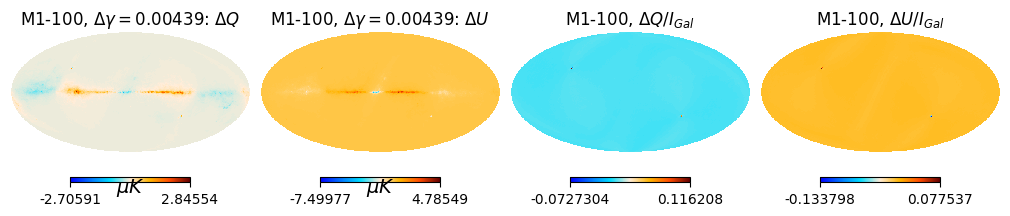

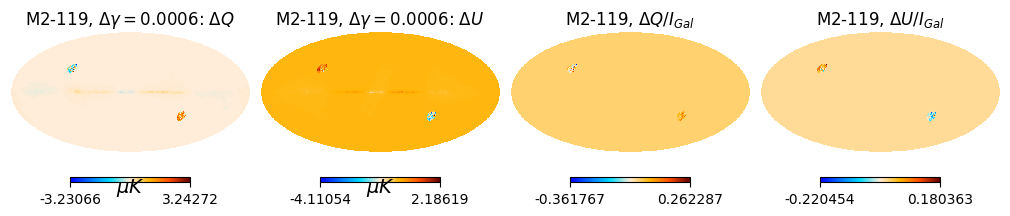

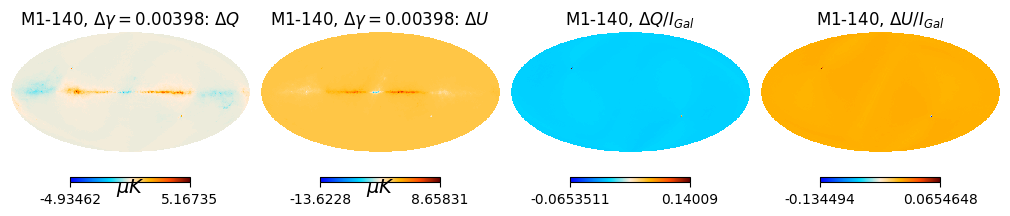

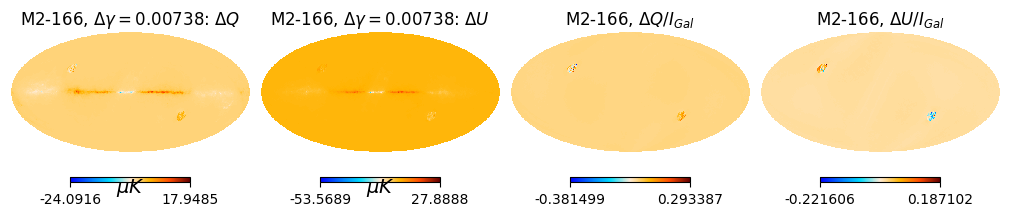

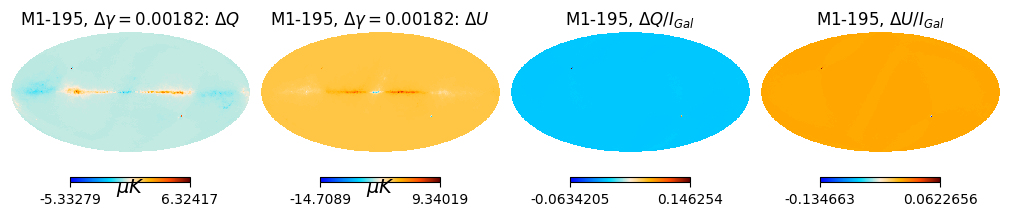

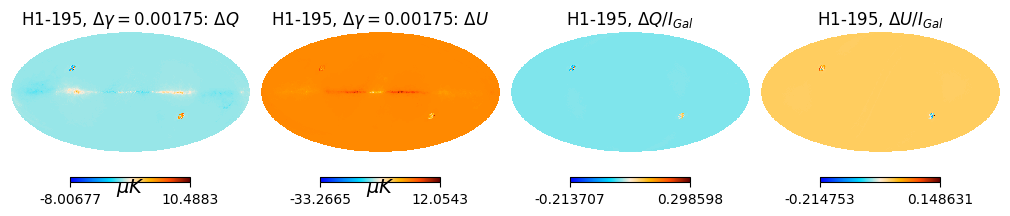

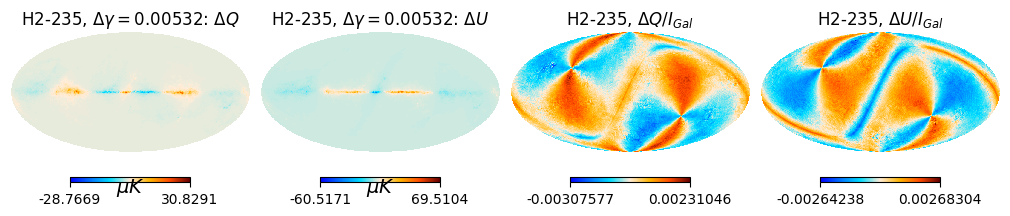

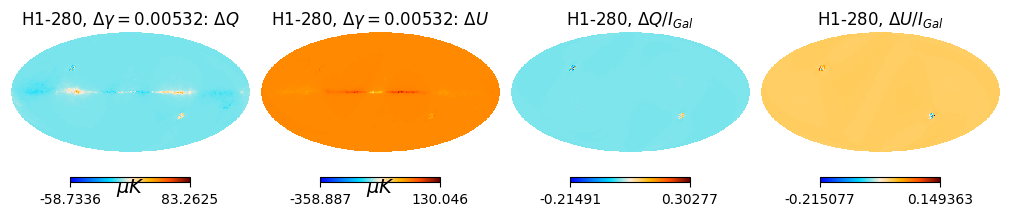

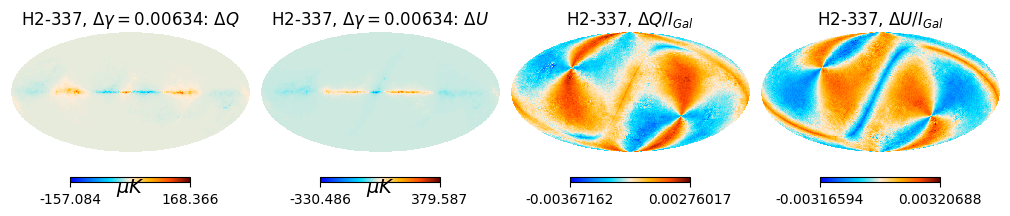

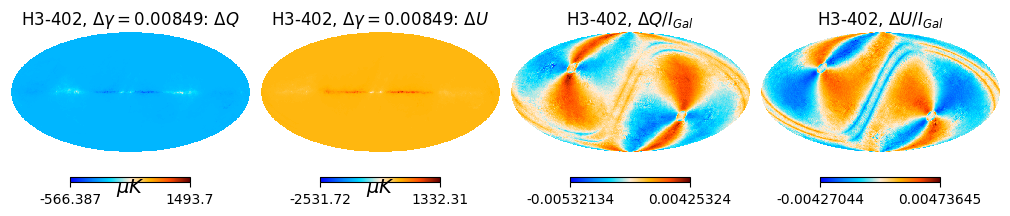

In [9]:
fg_models = ["pysm_dust_0", "pysm_synch_0"]
lmax = 3 * sf.nside - 1
sim = lbs.Simulation(random_seed=None)
mdim = 2
cmap = sbm.get_cmap()
#sim_channels = sbm.channel_list[:2] # Only two channels

sim_channels = sbm.channel_list
np.random.seed(123)
gamma_T = np.random.uniform(0.0, 0.01, len(sim_channels))
gamma_B = np.random.uniform(0.0, 0.0, len(sim_channels))

for i, channel in enumerate(sim_channels):
    telescope = channel[0] + "FT"
    print(f"Running channel: {channel}")

    Mbsparams = lbs.MbsParameters(
        make_cmb=False,
        cmb_r=0.0,
        make_fg=True,
        seed_cmb=33,
        fg_models=fg_models,
        gaussian_smooth=False,
        bandpass_int=False,
        nside=sf.nside,
        units="uK_CMB",
        maps_in_ecliptic=False,
    )
    ch_info = lbs.FreqChannelInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
        imo=imo,
    )
    mbs = lbs.Mbs(
        simulation=sim,
        parameters=Mbsparams,
        channel_list=ch_info,
    )
    map_info = mbs.run_all()[0]

    temp = map_info[channel][0]
    pol = map_info[channel][1] + 1j * map_info[channel][2]

    top_detector_list = ch_info.detector_names[0::2] # extract only Top detectors
    picked_up_detectors = top_detector_list[0:5] # pick up only 5 detectors from the top detectors
    print("Used dets: ", *picked_up_detectors) # print the detector to make cross-links

    scan_field = sbm.ScanFields.load_channel(channel, detector_list=picked_up_detectors)
    signal_field = sbm.SignalFields.diff_gain_field(
        scan_field,
        mdim,
        gamma_T[i],
        gamma_B[i],
        temp,
        pol,
    )

    delta_gamma = np.round(gamma_T[i] - gamma_B[i], 5)
    output_map = scan_field.map_make(signal_field, show_eq=False)
    residual = map_info[channel] - output_map
    figures = []
    fig = plt.figure(figsize=(10,5))
    hp.mollview(residual[1], title=f"{channel}, $\Delta \gamma={delta_gamma}$: $\Delta Q$", sub=(1, 4, 1), cmap=cmap, unit="$\mu K$")
    hp.mollview(residual[2], title=f"{channel}, $\Delta \gamma={delta_gamma}$: $\Delta U$", sub=(1, 4, 2), cmap=cmap, unit="$\mu K$")
    hp.mollview(residual[1]/temp, title=f"{channel}, $\Delta Q/I_{{Gal}}$", sub=(1, 4, 3), cmap=cmap)
    hp.mollview(residual[2]/temp, title=f"{channel}, $\Delta U/I_{{Gal}}$", sub=(1, 4, 4), cmap=cmap)
    figures.append(fig)

How mitigation help the leakage? 
The mitigation can be done by `mdim=2` to change `mdim=3`.

Running channel: L1-040
Used dets:  000_000_003_QA_040_T 000_000_004_QB_040_T 000_000_005_UA_040_T 000_000_006_UA_040_T 000_000_007_UB_040_T
Running channel: L2-050
Used dets:  000_000_000_QA_050_T 000_000_001_QB_050_T 000_000_002_UA_050_T 000_003_000_UB_050_T 000_003_001_UA_050_T
Running channel: L1-060
Used dets:  000_000_003_QA_060_T 000_000_004_QB_060_T 000_000_005_UA_060_T 000_000_006_UA_060_T 000_000_007_UB_060_T
Running channel: L3-068
Used dets:  000_001_018_UA_068_T 000_001_019_UB_068_T 000_001_020_QA_068_T 000_001_021_QB_068_T 000_001_022_UA_068_T
Running channel: L2-068
Used dets:  000_000_000_QA_068_T 000_000_001_QB_068_T 000_000_002_UA_068_T 000_003_000_UB_068_T 000_003_001_UA_068_T
Running channel: L4-078
Used dets:  000_001_000_QA_078_T 000_001_001_QB_078_T 000_001_002_UA_078_T 000_001_003_UB_078_T 000_001_004_QA_078_T
Running channel: L1-078
Used dets:  000_000_003_QA_078_T 000_000_004_QB_078_T 000_000_005_UA_078_T 000_000_006_UA_078_T 000_000_007_UB_078_T
Running chann

/tmp/ipykernel_2465676/1803216095.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,5))


Running channel: H3-402
Used dets:  002_002_000_Q_402_B 002_002_002_Q_402_B 002_002_004_Q_402_B 002_002_006_Q_402_B 002_002_008_Q_402_B


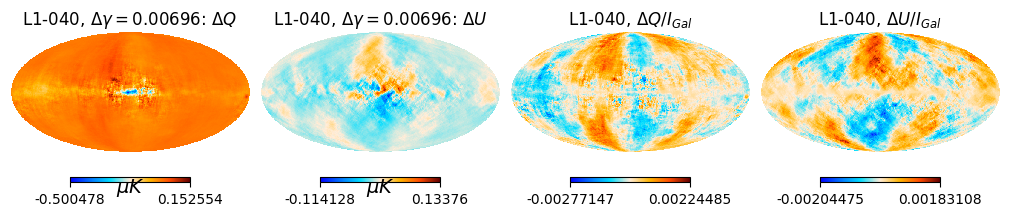

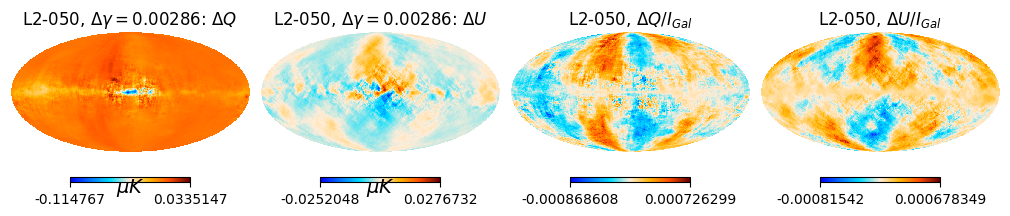

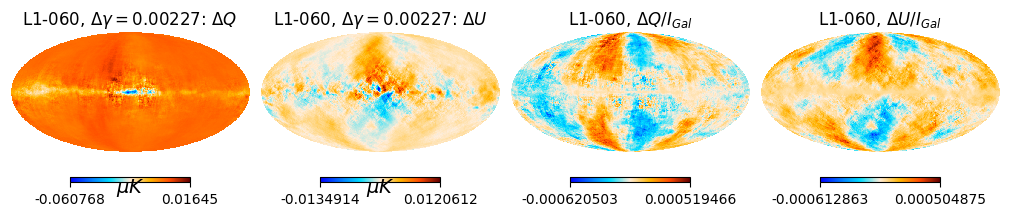

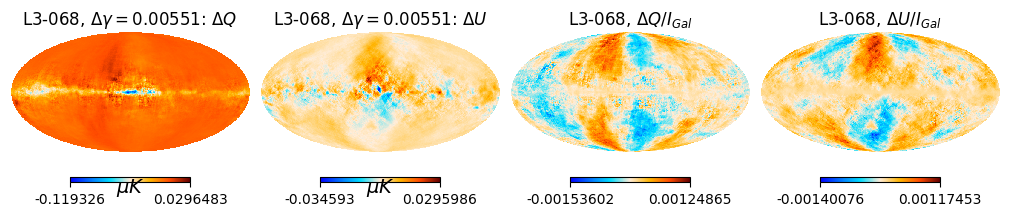

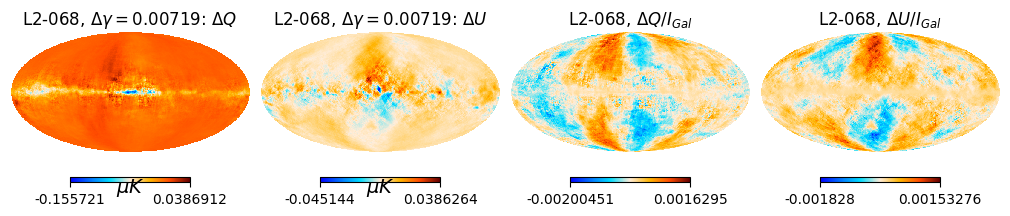

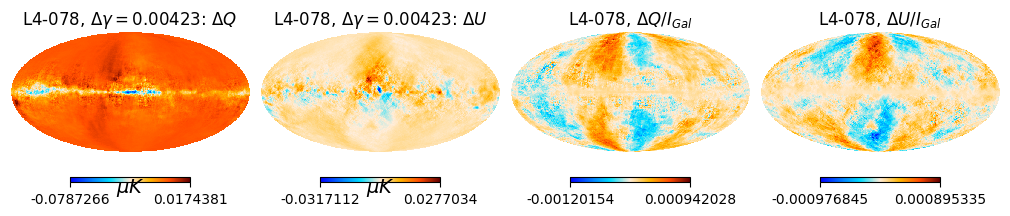

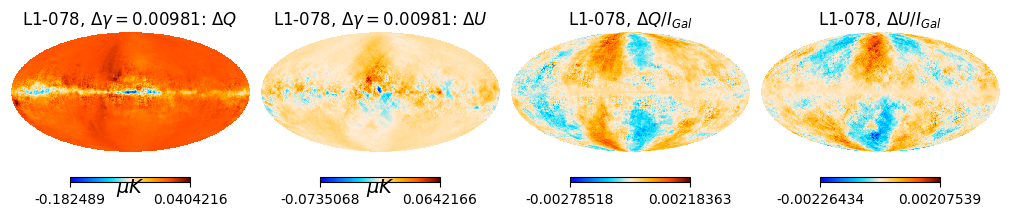

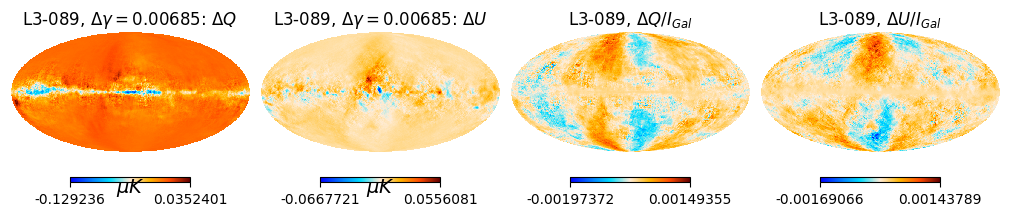

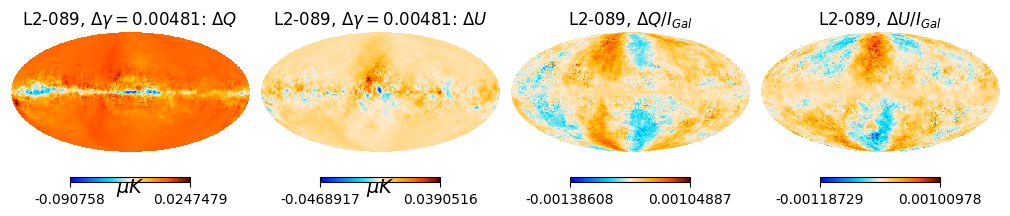

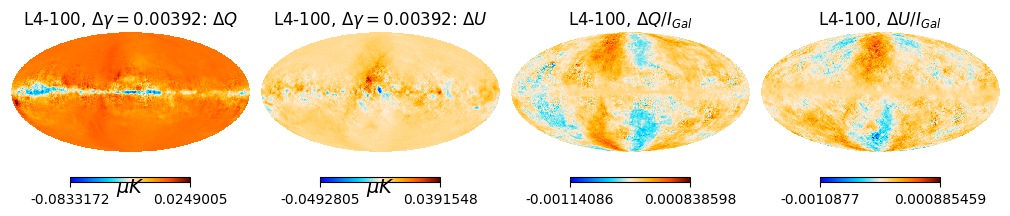

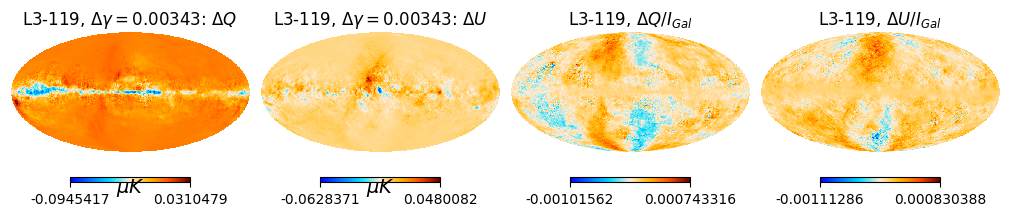

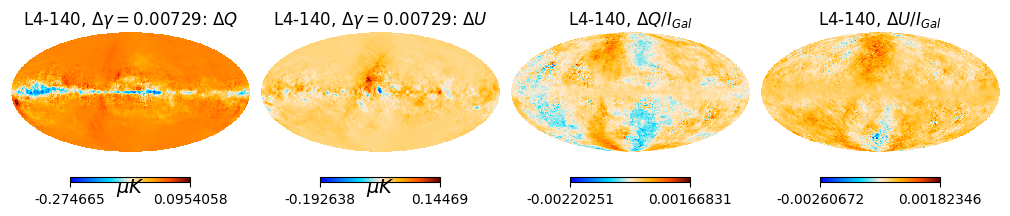

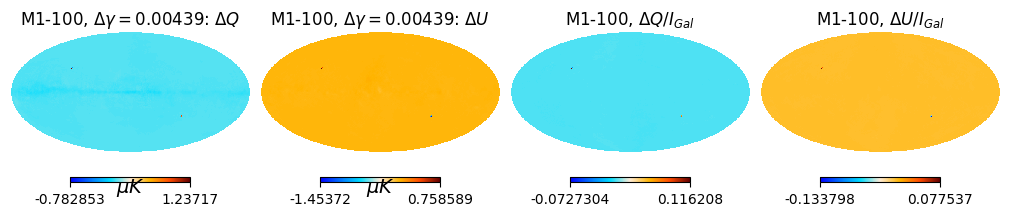

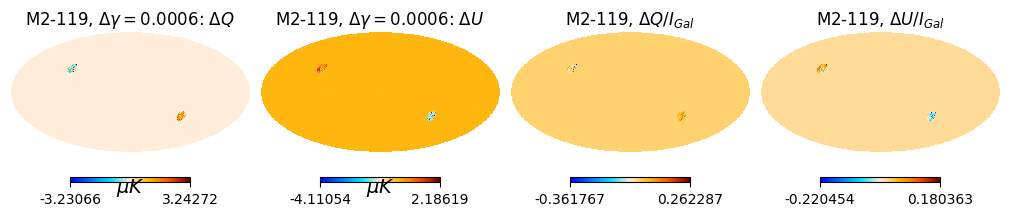

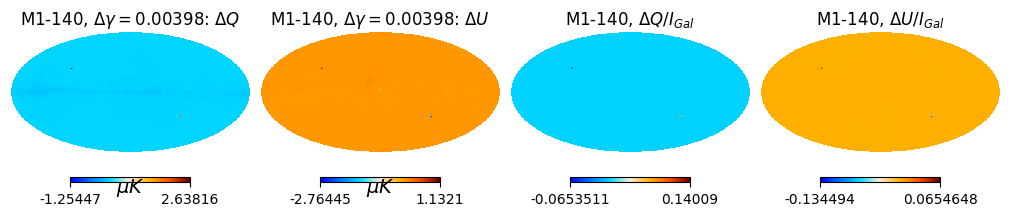

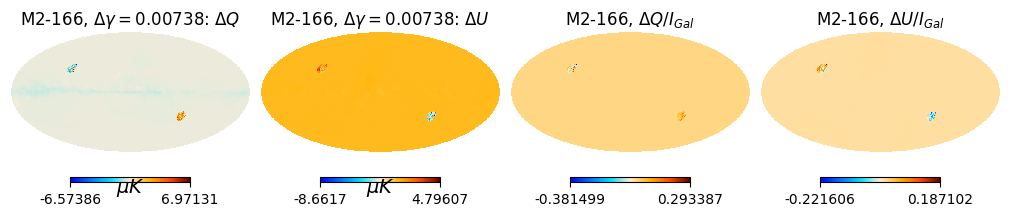

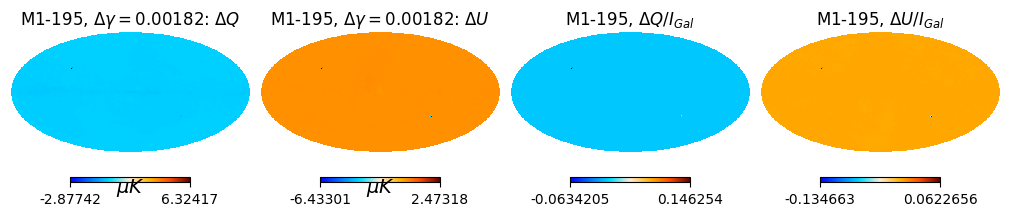

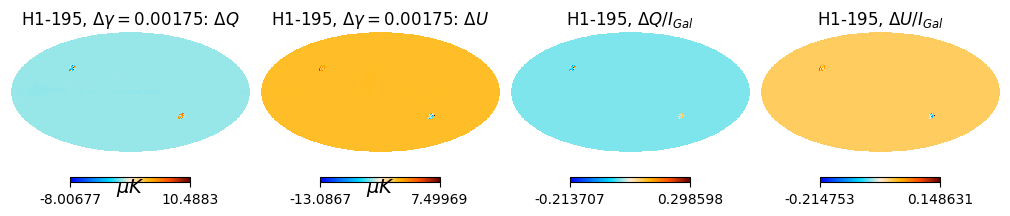

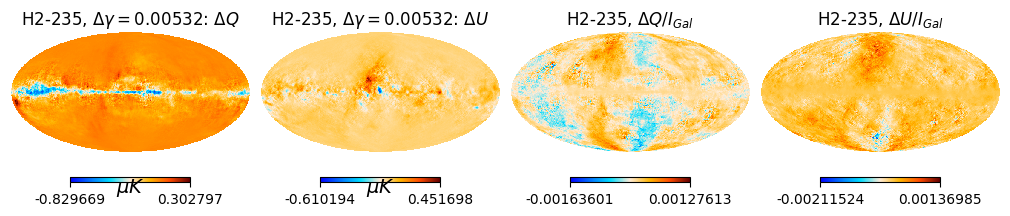

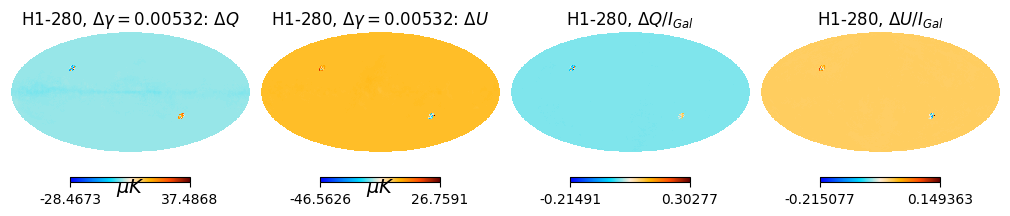

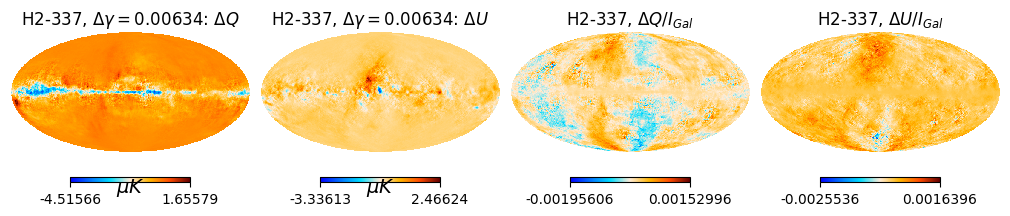

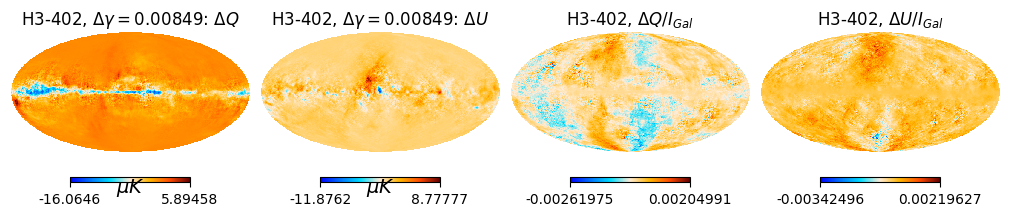

In [10]:
fg_models = ["pysm_dust_0", "pysm_synch_0"]
lmax = 3 * sf.nside - 1
sim = lbs.Simulation(random_seed=None)
mdim = 3
cmap = sbm.get_cmap()
#sim_channels = sbm.channel_list[:2] # Only two channels

sim_channels = sbm.channel_list
np.random.seed(123)
gamma_T = np.random.uniform(0.0, 0.01, len(sim_channels))
gamma_B = np.random.uniform(0.0, 0.0, len(sim_channels))

for i, channel in enumerate(sim_channels):
    telescope = channel[0] + "FT"
    print(f"Running channel: {channel}")

    Mbsparams = lbs.MbsParameters(
        make_cmb=False,
        cmb_r=0.0,
        make_fg=True,
        seed_cmb=33,
        fg_models=fg_models,
        gaussian_smooth=False,
        bandpass_int=False,
        nside=sf.nside,
        units="uK_CMB",
        maps_in_ecliptic=False,
    )
    ch_info = lbs.FreqChannelInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
        imo=imo,
    )
    mbs = lbs.Mbs(
        simulation=sim,
        parameters=Mbsparams,
        channel_list=ch_info,
    )
    map_info = mbs.run_all()[0]

    temp = map_info[channel][0]
    pol = map_info[channel][1] + 1j * map_info[channel][2]

    top_detector_list = ch_info.detector_names[0::2] # extract only Top detectors
    picked_up_detectors = top_detector_list[0:5] # pick up only 5 detectors from the top detectors
    print("Used dets: ", *picked_up_detectors) # print the detector to make cross-links

    scan_field = sbm.ScanFields.load_channel(channel, detector_list=picked_up_detectors)
    signal_field = sbm.SignalFields.diff_gain_field(
        scan_field,
        mdim,
        gamma_T[i],
        gamma_B[i],
        temp,
        pol,
    )

    delta_gamma = np.round(gamma_T[i] - gamma_B[i], 5)
    output_map = scan_field.map_make(signal_field, show_eq=False)
    residual = map_info[channel] - output_map
    figures = []
    fig = plt.figure(figsize=(10,5))
    hp.mollview(residual[1], title=f"{channel}, $\Delta \gamma={delta_gamma}$: $\Delta Q$", sub=(1, 4, 1), cmap=cmap, unit="$\mu K$")
    hp.mollview(residual[2], title=f"{channel}, $\Delta \gamma={delta_gamma}$: $\Delta U$", sub=(1, 4, 2), cmap=cmap, unit="$\mu K$")
    hp.mollview(residual[1]/temp, title=f"{channel}, $\Delta Q/I_{{Gal}}$", sub=(1, 4, 3), cmap=cmap)
    hp.mollview(residual[2]/temp, title=f"{channel}, $\Delta U/I_{{Gal}}$", sub=(1, 4, 4), cmap=cmap)
    figures.append(fig)